# Train Domain classifier from the [semantic scholar dataset](https://api.semanticscholar.org/corpus)

In [1]:
import json
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from sklearn import metrics, set_config
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

from good_ai.utilities.clean import clean
from good_ai.utilities.parallel_map import parallel_map
from good_ai.utilities.language import is_english, predict_language
from good_ai import save_model, set_default_config, LargeFile

from preprocess import preprocess
from config import model_key

## Configuration

In [2]:
PREFIX = "domain-"
DATASET_KEY = "ss-data"
MAX_FILE_COUNT = 5

In [3]:
set_default_config()
corpus_path = LargeFile(DATASET_KEY).get()

set_config(display="diagram")
plt.rcParams["figure.figsize"] = (30, 15)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 12
plt.rcParams["axes.xmargin"] = 0

INFO:good_ai:Defaults: configured ✅
INFO:open_s3:Fetching online versions of ss-data
INFO:open_s3:Found versions: [0]
INFO:open_s3:Lastest version of ss-data-0 is 0
INFO:open_s3:File ss-data-0 found in cache


## Preprocessing

In [4]:
def clean_file(p: Path) -> None:
    try:
        processed_path = p.with_name(f"{PREFIX}{p.stem}{p.suffix}")

        if processed_path.exists():
            return

        with open(p) as f:
            content = json.load(f)

        result = {
            preprocess(
                clean(f'{c["title"]} {c["abstract"]}', convert_to_ascii=True)
            ): c["domain"]
            for c in content
            if (
                c["domain"]
                and c["abstract"]
                and is_english(predict_language(c["abstract"]))
            )
        }

        with open(processed_path, "w") as f:
            json.dump(result, f)
    except Exception as e:
        print(f"Error ({e}) processing {p}")


parallel_map(
    clean_file,
    list(corpus_path.glob("s2-corpus-*.json"))[:MAX_FILE_COUNT],
    chunk_size=1,
)
None

100%|██████████| 5/5 [00:00<00:00, 43873.47it/s]


In [5]:
corpora = list(corpus_path.glob(f"{PREFIX}*.json"))[:MAX_FILE_COUNT]
print(f"Found {len(corpora)} files")

data = []
for p in corpora:
    with open(p) as f:
        data.extend(json.load(f).items())

print(f"Found {len(data)} documents")

X_train, X_test, y_train, y_test = train_test_split(
    [d[0] for d in data], [d[1] for d in data], test_size=0.1, random_state=1
)

X_train = [x for x, y in zip(X_train, y_train) for domain in y]
y_train = [domain for x, y in zip(X_train, y_train) for domain in y]

Found 5 files
Found 77176 documents


## Naive Bayes

In [6]:
classifier = GridSearchCV(
    Pipeline(steps=[("vectorizer", TfidfVectorizer()), ("classifier", ComplementNB())]),
    {
        "vectorizer__max_df": [0.05, 0.1, 0.3],
        "vectorizer__min_df": [5, 10, 30],
        "vectorizer__sublinear_tf": [True, False],
        "classifier__alpha": [0.001, 0.1, 0.5, 1],
        "classifier__fit_prior": [True, False],
    },
    scoring="f1_macro",
    cv=3,
    n_jobs=8,
    verbose=1,
)
classifier.fit(X_train, y_train)

results = pd.DataFrame(classifier.cv_results_)
results.sort_values("rank_test_score")

Fitting 3 folds for each of 144 candidates, totalling 432 fits


KeyboardInterrupt: 

In [ ]:
classifier = Pipeline(
    steps=[
        ("vectorizer", TfidfVectorizer(min_df=10, max_df=0.1, token_pattern=r"[^ ]+")),
        ("classifier", ComplementNB(alpha=0.5, fit_prior=False)),
    ]
)

classifier.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.1, min_df=10, token_pattern='[^ ]+')),
                ('classifier', ComplementNB(alpha=0.5, fit_prior=False))])

                       precision    recall  f1-score   support

                  Art       0.44      0.43      0.43        86
              Biology       0.79      0.75      0.77       567
             Business       0.56      0.58      0.57       223
            Chemistry       0.75      0.73      0.74       651
     Computer Science       0.61      0.85      0.71       773
            Economics       0.68      0.55      0.60       179
          Engineering       0.56      0.32      0.41       499
Environmental Science       0.48      0.32      0.38       132
            Geography       0.57      0.19      0.29       182
              Geology       0.67      0.66      0.66       144
              History       0.43      0.22      0.30        58
    Materials Science       0.66      0.84      0.74       630
          Mathematics       0.79      0.59      0.67       285
             Medicine       0.89      0.94      0.91      2151
           Philosophy       0.68      0.23      0.35  

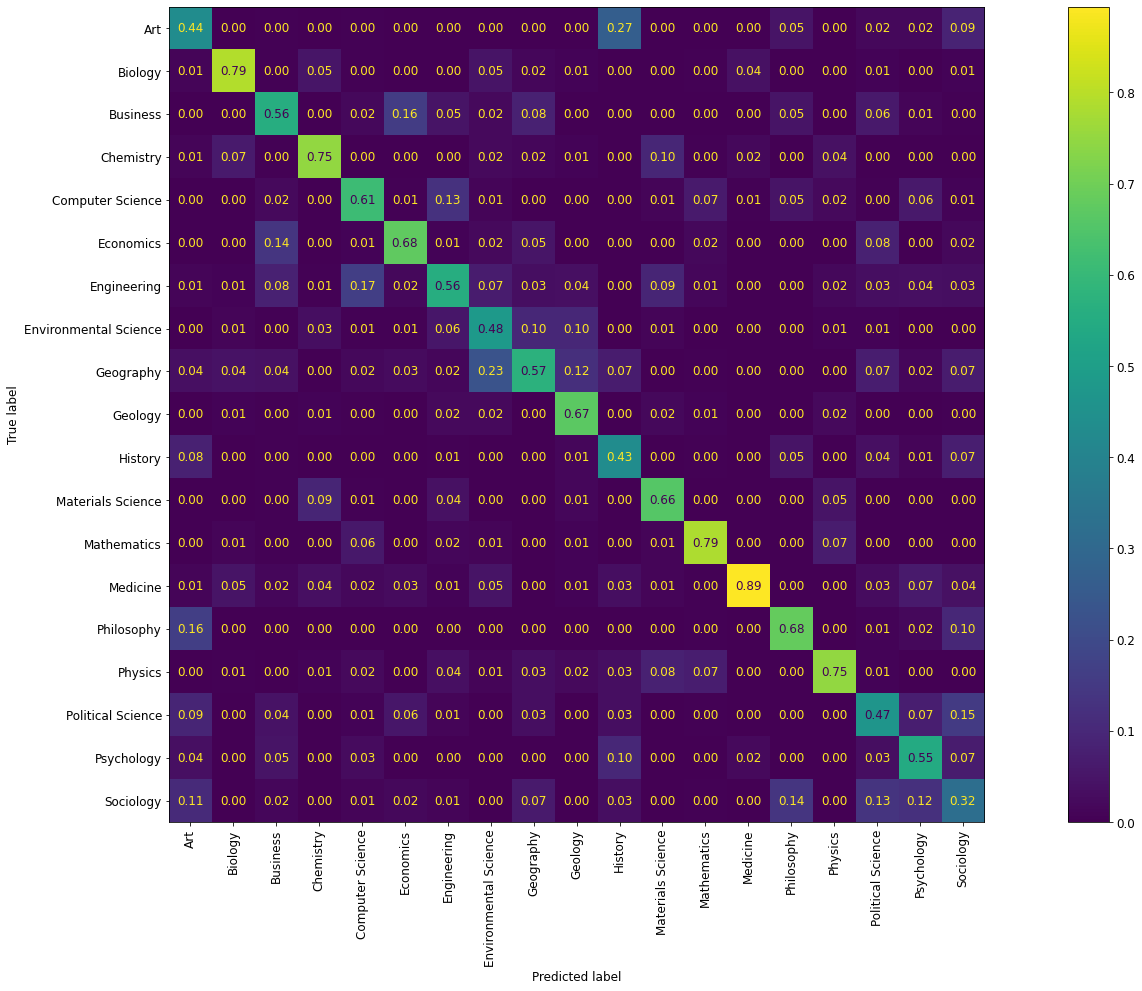

In [ ]:
predicted = classifier.predict(X_test)

y_test_aligned = [p if p in y else y[0] for p, y in zip(predicted, y_test)]

print(metrics.classification_report(y_test_aligned, predicted))
metrics.ConfusionMatrixDisplay.from_predictions(
    y_true=y_test_aligned,
    y_pred=predicted,
    xticks_rotation="vertical",
    normalize="pred",
    values_format=".2f",
)
None

In [ ]:
save_model(classifier, key=model_key, keep_last_n=1)

INFO:open_s3:Fetching online versions of domain-prediction-v2
INFO:open_s3:Found versions: [3, 4]
INFO:open_s3:Copying file for domain-prediction-v2-5
INFO:open_s3:Compressing domain-prediction-v2-5
INFO:open_s3:Uploading domain-prediction-v2-5 to S3 from /var/folders/5g/yd_5_wg548q0yb4lnvg0y3q40000gn/T/large-file-e5pc9s_c
INFO:open_s3:Uploading domain-prediction-v2-5.tar.gz   262144/15169569 bytes (1.7%)
INFO:open_s3:Uploading domain-prediction-v2-5.tar.gz   524288/15169569 bytes (3.5%)
INFO:open_s3:Uploading domain-prediction-v2-5.tar.gz   786432/15169569 bytes (5.2%)
INFO:open_s3:Uploading domain-prediction-v2-5.tar.gz  1048576/15169569 bytes (6.9%)
INFO:open_s3:Uploading domain-prediction-v2-5.tar.gz  1310720/15169569 bytes (8.6%)
INFO:open_s3:Uploading domain-prediction-v2-5.tar.gz  1572864/15169569 bytes (10.4%)
INFO:open_s3:Uploading domain-prediction-v2-5.tar.gz  1835008/15169569 bytes (12.1%)
INFO:open_s3:Uploading domain-prediction-v2-5.tar.gz  2097152/15169569 bytes (13.8%)


5